In [1081]:

import pandas as pd
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

###Import events dataset

C1= pd.read_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\C1.csv')
C2= pd.read_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\C2.csv')
C3=C1.append(C2)
#C3.to_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\C3.csv')

###Import Results dataset
A1= pd.read_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\A1.csv')
A2= pd.read_csv(r'C:\Users\Home\Documents\Atlanta 2021- OptaPro 2021\A2.csv')
A3=A1.append(A2)

In [1089]:
### Look at the short Goal Kicks to players inside the box first ####
A4=A3
key_sequences=A3.sequence.to_list()
C4=C3[C3['sequence'].isin(key_sequences)]

### Remove 2nd Consecutive zone interactions to keep pass,reception #### 
C4 = C4.loc[C4["playerId_x"]!=C4["playerId_x"].shift(-1)].reset_index(drop=True)
C4['ID_count'] = C4.groupby((C4['sequence'] != C4['sequence'].shift(1)).cumsum()).cumcount()+1


### Merge the two dataframes ###
AC4=pd.merge(C4,A4,on='sequence',how='left')

G=[]

for i in key_sequences:
    
    df=AC4[AC4['sequence']==i].reset_index(drop=True)
    df['New_Cols']=df.index % 3 == 0
    df["consec"] = df["New_Cols"].groupby((df["New_Cols"] == True).cumsum()).cumcount()+1
    df['zone1']=df['zone_x'].str.replace('Zone ','')
    df['next_zone1']=df['zone1'].shift(-1)
    df['next_zone2']=df['zone1'].shift(-2)
    df['next_zone3']=df['zone1'].shift(-3)
    df['next_zone4']=df['zone1'].shift(-4)
    df['next_pos1']=df['position'].shift(-1)
    df['next_pos2']=df['position'].shift(-2)
    df['next_pos3']=df['position'].shift(-3)
    df['next_pos4']=df['position'].shift(-4)
    df['prev_pos1']=df['position'].shift(1)
    df['prev_pos2']=df['position'].shift(2)
    df['prev_pos3']=df['position'].shift(3)
    df['prev_pos4']=df['position'].shift(4)
    df['prev_zone1']=df['zone1'].shift(1)
    df['prev_zone2']=df['zone1'].shift(2)
    df['prev_zone3']=df['zone1'].shift(3)
    df['prev_zone4']=df['zone1'].shift(4)
    
    G.append(df)
        
AC5=pd.concat(G)

In [1090]:
#### Cluster composition ####
sequence_list=list(C4.sequence.unique())

C4['zone1']=C4['zone'].str.replace('Zone ','')

A=[]

for i in sequence_list:
    df=C4[C4['sequence']==i].reset_index(drop=True)
    df=df.drop_duplicates(subset=['zone1'],keep='first', inplace=False)
    df['next_zone1']=df['zone1'].shift(-1)
    df['next_zone2']=df['zone1'].shift(-2)
    df['next_zone3']=df['zone1'].shift(-3)
    df['next_zone4']=df['zone1'].shift(-4)
    df['next_zone5']=df['zone1'].shift(-5)
    df['next_zone6']=df['zone1'].shift(-6)
    df['next_zone7']=df['zone1'].shift(-7)
    df['next_zone8']=df['zone1'].shift(-8)
    A.append(df)
        
B=pd.concat(A)
     
Check=B[B['ID_count']==1].reset_index(drop=True)
Check=pd.merge(Check,A4,on='sequence',how='left')

In [1091]:
Check['Final_zone']=Check['zone1'].astype(str)+Check['next_zone1'].astype(str)+Check['next_zone2'].astype(str)+Check['next_zone3'].astype(str)+Check['next_zone4'].astype(str)+Check['next_zone5'].astype(str)
Check['Final_zone']=Check['Final_zone'].str.replace('nan','')

In [1092]:
B1=pd.merge(C4,Check[['sequence','Final_zone']],on='sequence',how='left')
B1=B1[B1['markingType']!='reception'].reset_index(drop=True)

In [1093]:
len(B1.sequence.unique())

203

In [1094]:
df1 = pd.crosstab(B1['Final_zone'], B1['zone'].fillna('n/a'))
df2 = pd.crosstab(B1['Final_zone'], B1['position'].fillna('n/a'))

df1=pd.merge(df1,df2,left_index=True,right_index=True)

df1['Final_zone']=df1.index
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df1.set_index('Final_zone').loc[df1.Final_zone].index))
}
from scipy.sparse import csr_matrix
# transform matrix to scipy sparse matrix
df1=df1.iloc[:,:-1]

movie_user_mat_sparse = csr_matrix(df1.values)

# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(df1)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [1095]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 95:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        #print('Oops! No match is found')
        return
    if verbose:
        #print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
        return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    #print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    #print('Recommendation system start to make inference')
    #print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    #print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        #print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))
        
        return reverse_mapper[idx],dist

In [1096]:
G=[]
D=[]

for i in df1.index:
    A=pd.DataFrame(make_recommendation(model_knn=model_knn,data=movie_user_mat_sparse,fav_movie=i,mapper=movie_to_idx,n_recommendations=1))[:1]
    B=pd.DataFrame(make_recommendation(model_knn=model_knn,data=movie_user_mat_sparse,fav_movie=i,mapper=movie_to_idx,n_recommendations=2))[:1]
    C=pd.DataFrame(make_recommendation(model_knn=model_knn,data=movie_user_mat_sparse,fav_movie=i,mapper=movie_to_idx,n_recommendations=3))[:1]
    Final=pd.concat([A,B,C])
    Final=Final.T.set_axis(['First','Second','Third'], axis=1, inplace=False)
    G.append(Final)
    D.append(i)

D=pd.DataFrame(D).set_axis(['Final_zone'], axis=1, inplace=False)
G=pd.concat(G).reset_index(drop=True)
Combined=pd.merge(D,G,left_index=True,right_index=True)

In [1071]:
Combined1=pd.merge(Combined,Check[['Final_zone','sequence','Sequence_result']],on='Final_zone',how='inner')
Combined2=pd.merge(Combined1,Check[['Final_zone','sequence','Sequence_result']],left_on='First',
                   right_on='Final_zone',how='inner')
Combined3=pd.merge(Combined2,Check[['Final_zone','sequence','Sequence_result']],left_on='Second',
                   right_on='Final_zone',how='inner')

Combined4=pd.merge(Combined3,Check[['Final_zone','sequence','Sequence_result']],left_on='Third',
                   right_on='Final_zone',how='inner')

In [1072]:
Combined1=Combined1[['Final_zone','sequence','Sequence_result']]
#Combined4=Combined4.set_axis(['Final_zone','sequence'], axis=1, inplace=False)
Combined1

Final_zone    sequence  Sequence_result
0            1  12-2142465         Turnover
1           10   6-2142454         Turnover
2           10  11-2143023         Turnover
3          110   2-2143023  End-of-sequence
4           12  13-2124217         Turnover
..         ...         ...              ...
200         69   4-2142960         Turnover
201     765410   9-2142465         Turnover
202        796  10-2142465  End-of-sequence
203        874   7-2124210  End-of-sequence
204        911   4-2142465         Turnover

[205 rows x 3 columns]

In [1097]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [1109]:

my_favorite = '45610'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: 45610
Found possible matches in our database: ['45610', '495610', '475610', '456310', '453610', '4610', '4510', '4875610', '4325610', '46710', '45310', '45210', '42610', '42510', '41610', '41510', '410', '475310', '461011', '423510', '421510', '418610', '4910', '4798610', '4769810', '4716310', '4710', '4611', '4610328', '4591063', '4586', '4567', '4521', '4511', '4356', '4310', '4210', '4110', '4106', '4105', '49810', '48910', '48710', '48210', '47611', '47110', '45811', '45796', '45321', '45236', '43106', '42110', '41210']

Recommendation system start to make inference
......

Recommendations for 45610:
1: 46710, with distance of 0.2160705040978146
2: 4610, with distance of 0.20956630870073856
3: 48765, with distance of 0.20602012594522245
4: 45, with distance of 0.2046921225820526
5: 4567, with distance of 0.19924278260379003
6: 45310, with distance of 0.18291133107496116
7: 485, with distance of 0.17477756726318716
8: 4875610, with distance of 0.167294354041923

In [1102]:

### Implementing Minibatch Kmeans ###
from sklearn.cluster import MiniBatchKMeans
from matplotlib import pyplot
from numpy import unique
from numpy import where
from sklearn import preprocessing
from sklearn.decomposition import PCA

df1 = pd.crosstab(B1['sequence'], B1['zone'].fillna('n/a'))

df2 = pd.crosstab(B1['sequence'], B1['position'].fillna('n/a'))

df3=pd.merge(df1,df2,left_index=True,right_index=True)



X=pd.DataFrame(df3)

#K means Clustering
###We need to reduce all the 11 dimensions of the X_norm dataframe into 2, so will use PCA to do this.
###This essentially turns a set of correlated features into a set of linearly uncorrelated ones, capturing the greatest variablity between features. Of course now, the 2 PCA dimensions on their own are fairly meaningless
pca = PCA(n_components = 0.99).fit(X)

################ Plottting the vaariance ratio ################
#plt.plot(pca.explained_variance_ratio_)
#plt.xlabel('number of components')
#plt.ylabel('Explained variance');


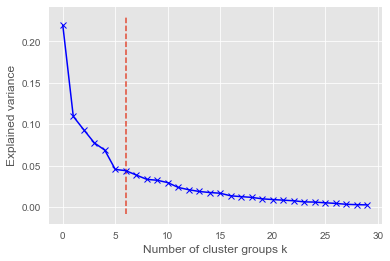

In [1103]:
import matplotlib.pyplot as plt
plt.xlabel('Number of cluster groups k')
plt.ylabel('Explained variance')
plt.plot(pca.explained_variance_ratio_, 'bx-')
from kneed import KneeLocator
pcadf=pd.DataFrame(pca.explained_variance_ratio_)
pcadf['x']=pcadf.index+1
pcadf=pcadf.set_axis(['y', 'x'], axis=1, inplace=False)
kn = KneeLocator(pcadf['x'],pcadf['y'], curve='convex', direction='decreasing')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

No handles with labels found to put in legend.


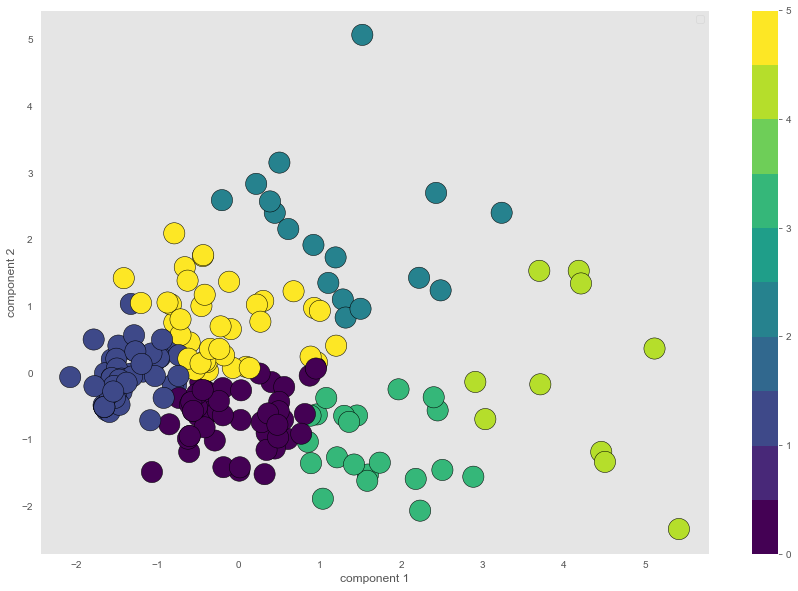

In [1104]:
#evr=pd.DataFrame(pca.explained_variance_ratio_)
#plt.style.use('ggplot')

# fit the model
pca = PCA(n_components=2).fit_transform(X)
model.fit(pca)

# Number of clusters
kmeans = MiniBatchKMeans(n_clusters=6, max_iter=100, n_init=1)
# Fitting the input data
kmeans = kmeans.fit(pca)
# Getting the cluster labels
labels = kmeans.predict(pca)
# Centroid values
C = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()

array1=pca[:, 0]
array2=pca[:, 1]


fig=plt.figure()
fig.set_size_inches(15, 10)
plt.scatter(pca[:, 0], pca[:, 1],c=clusters,edgecolor='black', alpha=1,
            cmap=plt.cm.get_cmap('viridis', 10),s=450)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()
plt.colorbar();

plt.grid(False)

df1['Clusters']=labels
df1['sequence']=df1.index

df1=df1.reset_index(drop=True)

In [1105]:
df1['sequence']=df1['sequence'].astype(str)

In [1106]:
df1_clusters=df1.iloc[:,11:]
AC6=pd.merge(df1_clusters,AC5,right_on='sequence',left_on='sequence',how='left')
AC7=pd.merge(Combined1,AC6,right_on='sequence',left_on='sequence',how='left')

In [1108]:
AC7.to_csv(r'C:\Users\Home\Documents\AC8.csv')

In [1021]:
A4.Sequence_result.value_counts()

Turnover           109
Success-Zone10      56
End-of-sequence     33
Success-Zone10d      9
Name: Sequence_result, dtype: int64

In [297]:
# calcuate total number of entries in the movie-user matrix
num_entries = df1.shape[0] * df1.shape[1]
# calculate total number of entries with zero values
num_zeros = (df1==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is zero'.format(ratio_zeros))

There is about 70.53% of ratings in our data is missing


<AxesSubplot:xlabel='id_count', ylabel='Zone 10'>

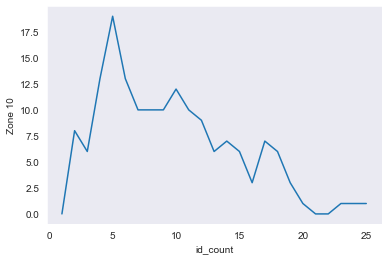

In [129]:
df2 = pd.crosstab(AC4['ID_count'], AC4['zone_x'].fillna('n/a'))
df2['id_count']=df2.index
df2=df2.reset_index(drop=True)

import seaborn as sns

sns.set_style("dark")
sns.lineplot(data=df2, y="Zone 10", x="id_count")

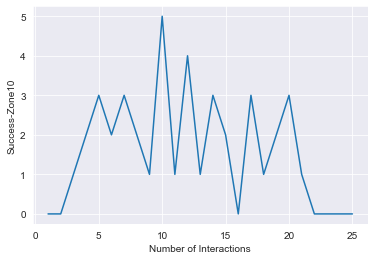

In [145]:
df2 = pd.crosstab(AC4['ID_count'], AC4['Sequence_result'])
df2['Number of Interactions']=df2.index
df2['Turnover']=(df2['Turnover']-df2['Turnover'].shift(-1)).fillna(0)
df2['End-of-sequence']=(df2['End-of-sequence']-df2['End-of-sequence'].shift(-1)).fillna(0)
df2['Success-Zone10']=df2['Success-Zone10']+df2['Success-Zone10d']
df2['Success-Zone10']=(df2['Success-Zone10']-df2['Success-Zone10'].shift(-1)).fillna(0)



df2=df2.reset_index(drop=True)
sns.set_style("darkgrid")
lineplot=sns.lineplot(data=df2, y='Success-Zone10', x="Number of Interactions")

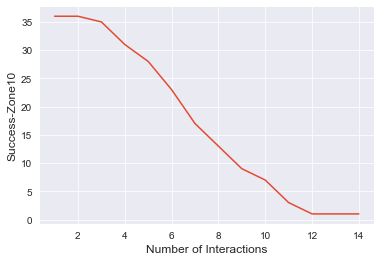

In [236]:
df2 = pd.crosstab(AC4['ID_count'], AC4['Sequence_result'].fillna('n/a'))
df2['Number of Interactions']=df2.index
df2=df2.reset_index(drop=True)
sns.set_style("darkgrid")
lineplot=sns.lineplot(data=df2, y='Success-Zone10', x="Number of Interactions")

In [180]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

fuzz.ratio("4478111111", "447861")



62

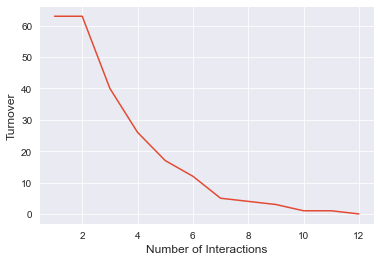

In [759]:
df2 = pd.crosstab(AC4['ID_count'], AC4['Sequence_result'])
df2['Number of Interactions']=df2.index
df2=df2.reset_index(drop=True)
sns.set_style("darkgrid")
lineplot=sns.lineplot(data=df2, y='Turnover', x="Number of Interactions")

# 